In [1]:
import pandas as pd
import pickle
import os
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
path_to_processed_dataset_folder = '/home/shoaib/gnn/gcn/datasets'

In [3]:
if os.path.exists(path_to_processed_dataset_folder):
  print("Directory exists")
else:
  print("Directory not exists")

Directory exists


In [4]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.utils import add_self_loops, coalesce
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from torch_geometric.utils import index_to_mask
from torch_geometric.nn import GCNConv, SAGEConv
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

In [5]:
torch.manual_seed(0)
np.random.seed(0)

In [6]:
# Load node attributes, adjacency matrix, and labels from .npy files
node_attributes = np.load(f'{path_to_processed_dataset_folder}/node_attributes.npy', allow_pickle = True)
adj = np.load(f'{path_to_processed_dataset_folder}/adjacency_matrix.npy', allow_pickle = True)
y = np.load(f'{path_to_processed_dataset_folder}/labels_v2.npy', allow_pickle = True)

In [7]:
node_attributes

array([[1.27, 11122.0, 11272.0, ..., 0.0, 0.0, 0.0],
       [1.06, 267.0, 1359.0, ..., 0.0, 0.0, 0.0],
       [1.33, 537.0, 409.0, ..., 0.0, 0.0, 0.0],
       ...,
       [14.511231890100216, 47.83230057107836, 14.0091382248733, ...,
        1.42, 0.94, 0.24],
       [13.5591, 45.29501831501835, 14.264175824175828, ..., 0.0, 0.0,
        1.01],
       [12.254254345995212, 61.67082158675014, 10.53875914973744, ...,
        1.4, 0.06, 2.02]], dtype=object)

In [8]:
# Convert adjacency matrix to edge index
edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)

# Convert node attributes to tensor
node_attributes = node_attributes.astype(np.float32)
x = torch.from_numpy(node_attributes).to(torch.float)

# Add self loops to the edge index
edge_index, _ = add_self_loops(edge_index, None)

# Coalesce the edge index
num_nodes = x.size(0)
edge_index, _ = coalesce(edge_index, None, num_nodes, num_nodes)

# Convert labels to tensor and pad with zeros
y = torch.from_numpy(y.squeeze()).to(torch.long)
#y = torch.cat((y, torch.zeros(num_nodes - y.size()[0], dtype=torch.long)))

# Create Data object
data = Data(x=x, edge_index=edge_index, y=y)

/tmp/ipykernel_12569/1763704804.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.tensor(adj.nonzero(), dtype=torch.long)


In [9]:
train_per = 0.8  # Adjust as needed

y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(range(y.size), y.squeeze(),
                                                    test_size=1 - train_per - 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=train_per / (train_per + 0.1), random_state=42)

train_index = torch.tensor(X_train, dtype=torch.long)
val_index = torch.tensor(X_val, dtype=torch.long)
test_index = torch.tensor(X_test, dtype=torch.long)

train_mask = index_to_mask(train_index, size=num_nodes)
val_mask = index_to_mask(val_index, size=num_nodes)
test_mask = index_to_mask(test_index, size=num_nodes)

data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [10]:
print(y)

[2 2 2 ... 1 1 1]


In [11]:
class SAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, 128)
        self.conv2 = SAGEConv(128, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        #x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=-1)

In [12]:
num_classes = len(np.unique(y))  # Adjust as needed
num_classes

3

In [13]:

model = SAGE(num_features=x.size(1), num_classes=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
path_to_saved_model_folder = '/home/shoaib/gnn/gcn/saved-models'
model_name = 'SAGE_model'
path = f'{path_to_saved_model_folder}/{model_name}.pth'

Fold 1 Test Accuracy: 0.918918918918919
Fold 1 Test F1 Score: 0.9188001188001188
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.94      0.89      0.91        18

    accuracy                           0.92        37
   macro avg       0.92      0.92      0.92        37
weighted avg       0.92      0.92      0.92        37



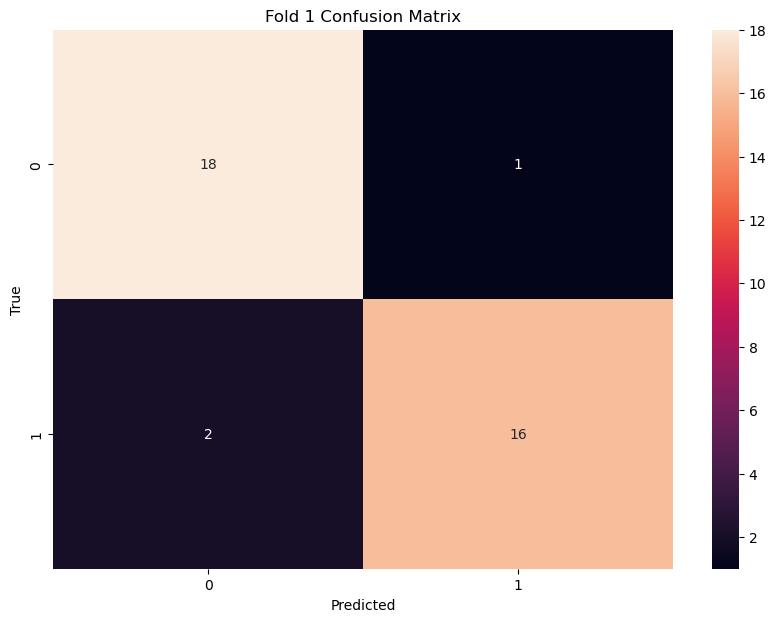

Fold 2 Test Accuracy: 0.8648648648648649
Fold 2 Test F1 Score: 0.861823563999108
Fold 2 Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       1.00      0.72      0.84        18

    accuracy                           0.86        37
   macro avg       0.90      0.86      0.86        37
weighted avg       0.89      0.86      0.86        37



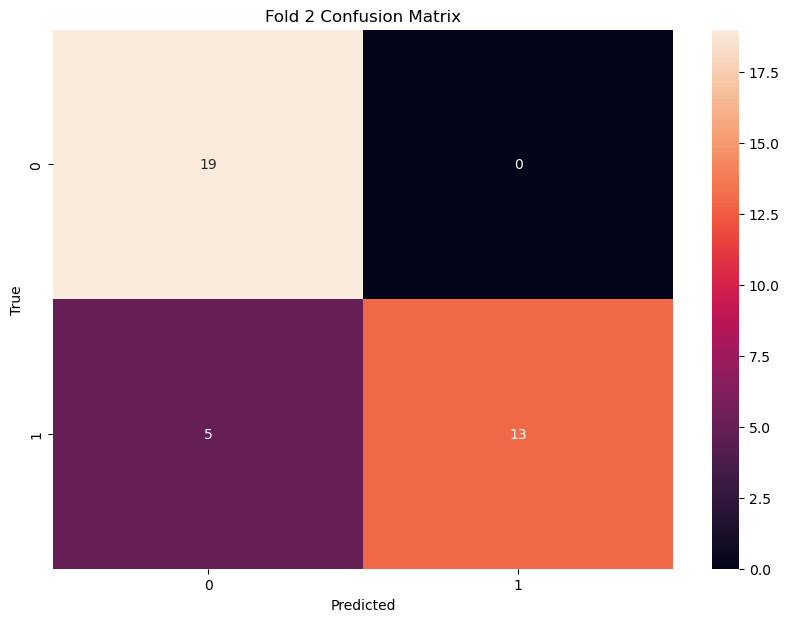

Fold 3 Test Accuracy: 0.8918918918918919
Fold 3 Test F1 Score: 0.8918918918918919
Fold 3 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.89      0.89      0.89        18

    accuracy                           0.89        37
   macro avg       0.89      0.89      0.89        37
weighted avg       0.89      0.89      0.89        37



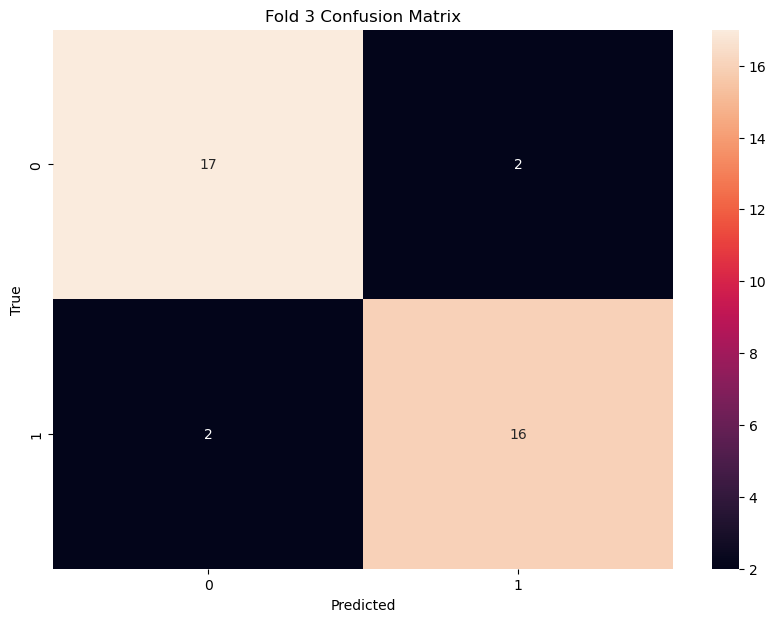

Fold 4 Test Accuracy: 0.7567567567567568
Fold 4 Test F1 Score: 0.757113157113157
Fold 4 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77        20
           1       0.72      0.76      0.74        17

    accuracy                           0.76        37
   macro avg       0.76      0.76      0.76        37
weighted avg       0.76      0.76      0.76        37



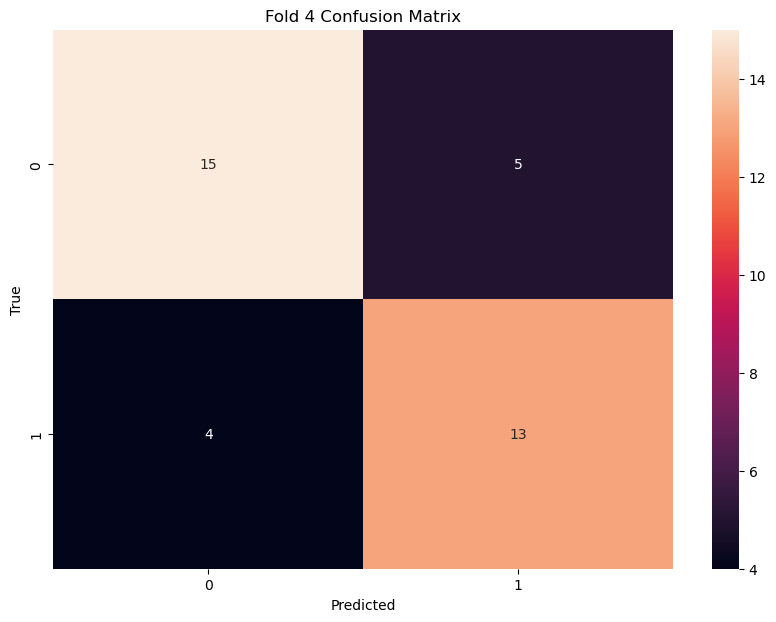

Fold 5 Test Accuracy: 0.8421052631578947
Fold 5 Test F1 Score: 0.8421052631578947
Fold 5 Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        20
           1       0.83      0.83      0.83        18

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38



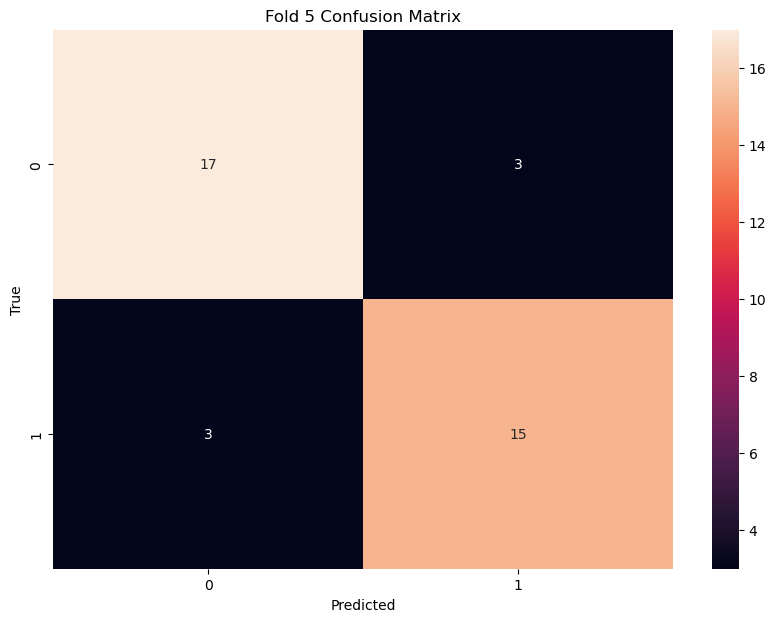

Average Test Accuracy: 0.8549075391180654
Average Test F1 Score: 0.8543467989924342


In [15]:
# Initialize the cross-validation splitter
cv = StratifiedKFold(n_splits=5)

# Initialize lists to store the accuracy and F1 score for each fold
accuracy_scores = []
f1_scores = []

# Perform cross-validation
for i, (train_index, test_index) in enumerate(cv.split(np.zeros(len(y)), y), start=1):
    # # Split the data into training and test sets
    data.train_mask = index_to_mask(torch.tensor(train_index), size=num_nodes)
    data.test_mask = index_to_mask(torch.tensor(test_index), size=num_nodes)

    # Load the best model
    model.load_state_dict(torch.load(path))

    # predictions with the best model
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.max(dim=1)[1]

    # Create a mask for the fake and real news
    news_mask = ((data.y == 0) | (data.y == 1)) & data.test_mask

    # Apply the mask to the labels and predictions
    labels_news = data.y[news_mask]
    preds_news = preds[news_mask]

    # Compute the accuracy and F1 score
    accuracy = accuracy_score(labels_news.cpu(), preds_news.cpu())
    f1 = f1_score(labels_news.cpu(), preds_news.cpu(), average='weighted')

    # Store the accuracy and F1 score
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f'Fold {i} Test Accuracy: {accuracy}')
    print(f'Fold {i} Test F1 Score: {f1}')

    report = classification_report(labels_news.cpu(), preds_news.cpu())
    print(f'Fold {i} Classification Report:')
    print(report)

    cm = confusion_matrix(labels_news.cpu(), preds_news.cpu())

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Fold {i} Confusion Matrix')
    plt.show()

# Compute the average accuracy and F1 score
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Test Accuracy: {average_accuracy}')
print(f'Average Test F1 Score: {average_f1}')

Table for fold-wise accuracy and F1 score, as well as the final average accuracy and F1 score:

| Fold | Accuracy | F1 Score |
|------|----------|----------|
| 1    | 0.9189   | 0.9188   |
| 2    | 0.8648   | 0.8618   |
| 3    | 0.8918   | 0.8918   |
| 4    | 0.7567   | 0.7571   |
| 5    | 0.8421   | 0.8421   |
| **Average** | **0.8549** | **0.8543** |
